# Homework 2

*Erick Hernández Silva A01750170*

*Israel Sánchez Miranda A01378705*

# 1. Introduction

This report outlines the implementation and evaluation of a genetic algorithm to solve optimization problems using both binary and real encoding. The algorithm is applied to two widely used benchmark functions: the Rosenbrock function and the Rastrigin function. Additionally, the performance of the genetic algorithm is compared to traditional optimization methods, including hill climbing, gradient descent, and Newton’s method.

# 2. Problem description

## 2.1. Genetic Algorithm Considerations

Two test problems were used to evaluate the genetic algorithm:

### Test Problem 1 (Rosenbrock Function)

A non-convex optimization problem used to evaluate optimization algorithms. The function is defined as:

$$
f(x) = 100(x_2 - x_1^2)^2 + (1 - x_1)^2 \text{ where } x_1,x_2 \in [-2.048, 2.048]
$$

### Test Problem 2 (Rastrigin Function)

This function is highly multimodal with a large number of local minima, making it challenging for optimization algorithms. The function is defined as:

$$
f(x) = 10n + \sum_{i=1}^{n} \left[ x_i^2 - 10 \cos(2\pi x_i) \right] \text{ where } x_i \in [-5.12, 5.12]
$$

### Binary Encoding

For binary encoding, 16 bits were used to represent the real values, allowing four digits of precision.


## 2.2. Genetic Algorithm Implementation

The genetic algorithm was implemented with two encoding strategies: **binary** and **real** encoding. For each encoding, specific crossover, mutation, and selection operators were applied.

- **Binary Encoding:**
  - **Initialization**: Random initialization of population.
  - **Crossover**: Single-point crossover with a probability \( $P_c = 0.9$ \).
  - **Mutation**: Binary mutation with a probability \( $P_m = \frac{1}{n}$ \).
  - **Selection**: Roulette wheel selection.

- **Real Encoding:**
  - **Initialization**: Random initialization of population.
  - **Crossover**: Simulated Binary Crossover (SBX) with a distribution index \( $n_c = 20$ \) and crossover probability \( $P_c = 0.9$ \).
  - **Mutation**: Parameter-based mutation (PM) with mutation parameter \( $n_m = 20$ \).
  - **Selection**: Binary tournament selection.

The genetic algorithm's goal was to minimize the objective functions (Rosenbrock and Rastrigin) for different problem sizes.


# 3. Experimental Phase

For each test problem, the genetic algorithm was run for both binary and real encoding over 20 independent runs. The population size was fixed at 100, and the algorithm was allowed to run for 100 generations. The experiments were performed for the following cases:

- **Test Problem 1 (Rosenbrock function)**.
- **Rastrigin Function** for \( $n = 2$ \) and \( $n = 5$ \).

During each run, the best individual’s fitness was recorded at every generation to evaluate the algorithm's convergence.

To implement these algorithms, we firs import the necesry libraries and define required constants

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Constants.

In [2]:
# Global constants for problems
ROSENBROCK_BOUNDS = [-2.048, 2.048] # Bounds stated for the Rosenbrock function
RASTRIGIN_BOUNDS = [-5.12, 5.12] # Bounds stated for the Rastringin function
PC_BINARY = 0.9  # Crossover probability for binary encoding
PC_REAL = 0.9  # Crossover probability for real encoding
PM_BINARY = 1 / 16  # Mutation probability for binary encoding
PM_REAL = 1 / 16  # Mutation probability for real encoding
N_C = 20  # Distribution index for SBX crossover
N_P = 20  # Mutation parameter

## Target functions.

We define the target functions and their jacobians and hessians for later comparison.

In [3]:
# Target functions for fitness evaluation
def rosenbrock(x):
  return 100 * (x[1] - x[0]**2)**2 + (1 - x[0])**2

def rastrigin(x, A=10):
  return A * len(x) + sum(xi**2 - A * np.cos(2 * np.pi * xi) for xi in x)

In [4]:
# Jacobian (Gradient) of Rosenbrock
def rosenbrock_jac(x):
  jac = np.zeros_like(x)
  jac[0] = -400 * (x[1] - x[0]**2) * x[0] - 2 * (1 - x[0])
  jac[1] = 200 * (x[1] - x[0]**2)
  return jac

# Hessian of Rosenbrock
def rosenbrock_hess(x):
  hess = np.zeros((len(x), len(x)))
  hess[0, 0] = 1200 * x[0]**2 - 400 * x[1] + 2
  hess[0, 1] = -400 * x[0]
  hess[1, 0] = -400 * x[0]
  hess[1, 1] = 200
  return hess

In [5]:
# Jacobian (Gradient) of Rastrigin
def rastrigin_jac(x, A=10):
  return 2 * np.array(x) + 2 * np.pi * A * np.sin(2 * np.pi * np.array(x))

# Hessian of Rastrigin
def rastrigin_hess(x, A=10):
  return np.diag(2 + 4 * np.pi**2 * A * np.cos(2 * np.pi * np.array(x)))

## Encoding.

We define two functions for binary encoding: One for encoding a real value array into a binary array and other one for decoding it.

In [6]:
# Helper functions for binary encoding/decoding
def real_to_binary(real_values, bounds, n_bits):
  """Convert a real value within bounds to a binary representation."""
  chromosome = []
  for value in real_values:
    # Normalize the real value to [0, 1]
    normalized_value = (value - bounds[0]) / (bounds[1] - bounds[0])
    
    # Scale the normalized value to [0, 2^n_bits - 1] and convert to integer
    integer_value = int(normalized_value * (2**n_bits - 1))
    
    # Convert integer to binary string and ensure correct bit length
    binary_str = format(integer_value, f'0{n_bits}b')  # Pad with zeros if needed
    
    # Convert the binary string to a list of integers (0 or 1)
    chromosome.extend([int(bit) for bit in binary_str])
  
  return np.array(chromosome)

In [7]:
def binary_to_real(binary_chrom, bounds, n_bits):
  decoded = []
  dim = len(binary_chrom) // n_bits

  # Divide the chromosome into chunks of `n_bits` bits
  for i in range(dim):
    # Extract the binary substring for this dimension
    start = i * n_bits
    end = start + n_bits
    binary_str = binary_chrom[start:end]
    
    # Convert the binary string (list of bits) to an integer
    integer_value = int(''.join(map(str, binary_str)), 2)
    
    # Map the integer to a real number within the specified bounds
    lower_bound, upper_bound = bounds[i] if isinstance(bounds[0], (tuple, list)) else bounds
    real_value = lower_bound + (upper_bound - lower_bound) * integer_value / (2**n_bits - 1)
    
    decoded.append(real_value)
  
  return decoded

## Crossover.

We define the crossover functions for binary and real encoding.

In [8]:
# Binary encoding crossover and mutation
def single_point_crossover(p1, p2):
  point = np.random.randint(1, len(p1))
  child1 = np.concatenate((p1[:point], p2[point:]))
  child2 = np.concatenate((p2[:point], p1[point:]))
  return child1, child2

# Real encoding crossover (SBX) and mutation
def sbx_crossover(p1, p2, nc):
  child1, child2 = np.zeros_like(p1), np.zeros_like(p2)
  for i in range(len(p1)):
    u = np.random.rand()
    if u <= 0.5:
      beta = (2 * u)**(1 / (nc + 1))
    else:
      beta = (1 / (2 * (1 - u)))**(1 / (nc + 1))
    child1[i] = 0.5 * ((1 + beta) * p1[i] + (1 - beta) * p2[i])
    child2[i] = 0.5 * ((1 - beta) * p1[i] + (1 + beta) * p2[i])
  return child1, child2

## Mutation.

We define the mutation functions.

In [9]:
def binary_mutation(chrom):
  # Select a random index in the chromosome
  mutation_index = np.random.randint(0, len(chrom))
  # Flip the bit at the selected index
  chrom[mutation_index] = 1 - chrom[mutation_index]  
  return chrom

def pm_mutation(chrom, bounds, gen):
  # Select a random index in the chromosome
  mutation_index = np.random.randint(0, len(chrom))
  
  # Compute delta based on the selected allele
  delta = abs(min(chrom[mutation_index] - bounds[0], bounds[1] - chrom[mutation_index]) / (bounds[0] - bounds[1]))
  nm = 100 + gen
  delta_q = 0
  eps = 1e-8
  
  # Apply the mutation formula based on delta
  if delta < 0.5:
    delta_q = (2 * delta + eps)**(1 / (nm + 1)) - 1
  else:
    delta_q = 1 - (2 * (1 - delta + eps))**(1 / (nm + 1))
  
  # Apply mutation to the selected allele
  chrom[mutation_index] += delta_q * (bounds[1] - bounds[0])
  chrom[mutation_index] = np.clip(chrom[mutation_index], bounds[0], bounds[1])  # Ensure the value stays within bounds
    
  return chrom

## Selection.

We define the selection algorithms

In [10]:
def roulette_wheel_selection(population, fitness):
    # Transform fitness for minimization (shift and scale to make small values more likely)
    max_fitness = max(fitness)
    min_fitness = min(fitness)
    
    # Ensure that fitness values are positive and smaller fitness values are weighted higher
    transformed_fitness = [max_fitness - f + 1e-6 for f in fitness]  # Add a small value to avoid zero fitness

    # Compute cumulative probability for roulette selection
    total_fitness = sum(transformed_fitness)
    probabilities = [f / total_fitness for f in transformed_fitness]
    cumulative_probabilities = np.cumsum(probabilities)

    # Obtain a random number in [0, 1]
    r = np.random.rand()

    # Select the individual based on the random number and cumulative probabilities
    for i, cum_prob in enumerate(cumulative_probabilities):
        if r <= cum_prob:
            return population[i]
    
    return population[-1]  # Fallback in case of rounding error


In [11]:
def binary_tournament_selection(population, fitness):
    population_copy = population[:]  # Create a copy of the population to manipulate
    fitness_copy = fitness[:]        # Copy fitness array to manipulate
    
    while len(population_copy) > 1:
        winner_arr = []
        
        # Perform selection in pairs
        while len(population_copy) >= 2:
            # Randomly select two individuals
            first_idx, second_idx = np.random.choice(len(population_copy), size=2, replace=False)
            
            first_individual = population_copy[first_idx]
            second_individual = population_copy[second_idx]
            
            # Compare their fitness and select the winner
            if fitness_copy[first_idx] < fitness_copy[second_idx]:
                winner_arr.append(first_individual)
            else:
                winner_arr.append(second_individual)
            
            # Remove both individuals from the population
            del population_copy[max(first_idx, second_idx)]
            del fitness_copy[max(first_idx, second_idx)]
            del population_copy[min(first_idx, second_idx)]
            del fitness_copy[min(first_idx, second_idx)]

        # If odd number of individuals, automatically advance the last individual
        if len(population_copy) == 1:
            winner_arr.append(population_copy[0])
        
        # Set the population for the next round
        population_copy = winner_arr
        fitness_copy = [fitness[i] for i in range(len(population_copy))]

    # Return the last remaining winner
    return population_copy[0]

## Genetic Algorithm.

Finally, we define a simple genetic algorithm which consists on the following steps: 
1. Randomly initialize the a population with the specified bounds, decision variables and population size.
2. If encoding is binary, then encode the generated chromosome.
3. Initialize a loop with the specified number of generations:

   3.1. If population is encoded then decode it to calculate its fitness, if not just evaluatew the fitness over the real-encoded chromosome.

   3.2. Use the specified selection mechanism for each encoding to select the parents of the next generation based on their fitness.

   3.3. If probabilities are met, rossover the two parent to make two children, if not, the parents become the children of the next generation.

   3.4. If probabilities are met, mutate the children generated in the step before.

   3.5. Now the new population is the two children generated by the steps before.

   3.6. Track the best fitness of the current generation adn store it.

   3.7. Check for stagnation, if no significative changehas been made in the last 5 generations (below a specified threshold of $1\times10^{-6}$), then early stop the process.
   
4. Return the convergene array, an array with the best fitness per generation.

In [12]:
# Genetic Algorithm framework
def genetic_algorithm(fitness_function, bounds, dim, encoding_type="binary", n_generations=100, pop_size=100, n_bits=16, stop_threshold=1e-6, stagnation_generations=5, verbose=False):
    # Create initial population as real values
    population = [np.random.uniform(bounds[0], bounds[1], dim) for _ in range(pop_size)]
    
    if verbose:
        print(f'Original population: {population}')

    if encoding_type == "binary":
        # Convert real values to binary representations
        population = [real_to_binary(ind, bounds, n_bits) for ind in population]

    if verbose:
        print(f'{encoding_type.title()} encoded population: {population}')

    best_fitness_per_gen = []
    
    for gen in range(n_generations):
        if encoding_type == "binary":
            # Convert binary population to real values for fitness evaluation
            real_population = [binary_to_real(ind, bounds, n_bits) for ind in population]
        else:
            real_population = population
        
        # Clip the values of the real population to ensure they stay within bounds
        real_population = [np.clip(ind, bounds[0], bounds[1]) for ind in real_population]

        if verbose:
            print(f'Clipped population (generation {gen + 1}): {real_population}')

        # Evaluate fitness
        fitness = [fitness_function(ind) for ind in real_population]
        
        if encoding_type == "binary":
            new_population = []
            for _ in range(pop_size // 2):
                p1 = roulette_wheel_selection(population, fitness)
                p2 = roulette_wheel_selection(population, fitness)
                if np.random.rand() < PC_BINARY:
                    c1, c2 = single_point_crossover(p1, p2)
                else:
                    c1, c2 = p1, p2
                if np.random.rand() < PM_BINARY:
                    c1 = binary_mutation(c1)
                    c2 = binary_mutation(c2)
                new_population.extend([c1, c2])
            population = new_population
        else:
            new_population = []
            for _ in range(pop_size // 2):
                p1 = binary_tournament_selection(population, fitness)
                p2 = binary_tournament_selection(population, fitness)
                if np.random.rand() < PC_REAL:
                    c1, c2 = sbx_crossover(p1, p2, N_C)
                else:
                    c1, c2 = p1, p2
                c1 = pm_mutation(c1, bounds, gen)
                c2 = pm_mutation(c2, bounds, gen)
                new_population.extend([c1, c2])
            population = new_population

        # Track best fitness
        best_fitness = min(fitness)
        best_fitness_per_gen.append(best_fitness)

        if verbose:
            print(f"Generation {gen + 1}, Best Fitness: {best_fitness}")

        # Check for stagnation (early stopping)
        if gen >= stagnation_generations:
            recent_fitness = best_fitness_per_gen[-stagnation_generations:]
            fitness_change = max(recent_fitness) - min(recent_fitness)

            if fitness_change < stop_threshold and verbose:
                print(f"Early stopping at generation {gen + 1} due to insufficient improvement.")
                break

    return best_fitness_per_gen

## Testing the algorithm

We tested the corret implementation of the algorithm with two test problems. For this testing we ativated the `verbose` option of the algorithm.

Original population: [array([-0.6602498 ,  0.19904935]), array([0.26583923, 1.12955188]), array([-1.54799708, -1.53295934]), array([-1.3018852, -1.8091011]), array([ 1.10454751, -0.03927624]), array([-0.01023679,  2.02759673]), array([1.50978318, 0.77917789]), array([ 1.50585928, -0.72642502]), array([-0.86189687,  1.11604949]), array([0.36210951, 0.91924896]), array([-0.46093978, -1.98897939]), array([ 1.55454706, -0.0951373 ]), array([0.55923288, 0.86965486]), array([-0.23603816, -0.12701877]), array([-0.69198224, -0.00736847]), array([ 2.01495188, -1.72239972]), array([ 1.52915895, -1.65958854]), array([-1.44771623, -0.46938008]), array([0.29442517, 0.93080535]), array([2.04784644, 0.02377734]), array([-1.65012103, -1.64745567]), array([-0.6693499 , -0.81828939]), array([0.19762693, 1.4304141 ]), array([ 0.61238834, -1.06394929]), array([0.60813375, 0.98387415]), array([ 0.67714036, -0.91279001]), array([-0.65829196,  1.73685665]), array([-1.78715711,  0.74764191]), array([-0.440017

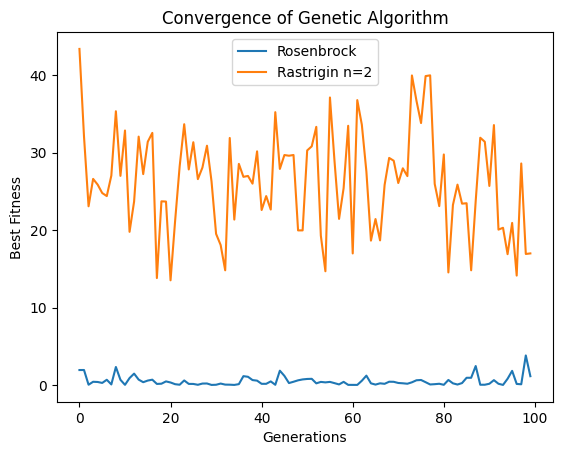

In [13]:
# Run for Rosenbrock (Test problem 1)
best_fitness_rosenbrock = genetic_algorithm(rosenbrock, ROSENBROCK_BOUNDS, 2, "binary", verbose=True)

# Run for Rastrigin n=2
best_fitness_rastrigin_2 = genetic_algorithm(lambda x: rastrigin(x, A=10), RASTRIGIN_BOUNDS, 5, "binary", verbose=True)

# Plot convergence graph
plt.plot(best_fitness_rosenbrock, label="Rosenbrock")
plt.plot(best_fitness_rastrigin_2, label="Rastrigin n=2")
plt.title("Convergence of Genetic Algorithm")
plt.xlabel("Generations")
plt.ylabel("Best Fitness")
plt.legend()
plt.show()

## Problem experimentation

We now we experiment with the algorithm using the configurations explained before.

In [14]:
# Problems and parameters
problems = {
    'Rastrigin n=1': rastrigin,  # For binary encoding
    'Test Problem 1': rosenbrock,   # Only for real encoding
    'Rastrigin n=2': rastrigin,     # Only for real encoding
    'Rastrigin n=5': rastrigin      # Only for real encoding
}

bounds = {
    'Rastrigin n=1': RASTRIGIN_BOUNDS,
    'Test Problem 1': ROSENBROCK_BOUNDS,
    'Rastrigin n=2': RASTRIGIN_BOUNDS,
    'Rastrigin n=5': RASTRIGIN_BOUNDS
}

dimensions = {
    'Rastrigin n=1': 1,
    'Test Problem 1': 2,
    'Rastrigin n=2': 2,
    'Rastrigin n=5': 5
}

encoding_types = ['binary', 'real']

# Experiment parameters
n_experiments = 20
n_generations = 100
pop_size = 100
n_bits = 16

# Initialize the results dictionary
results = {}

# Run experiments for each problem and encoding type
for problem_name in problems:
    fitness_function = problems[problem_name]
    bound = bounds[problem_name]
    dim = dimensions[problem_name]
    results[problem_name] = {}
    for encoding in encoding_types:
        # Skip incompatible combinations (binary encoding with multi-dimensional problems
        all_best_fitness = []
        all_convergence = []
        for exp in range(n_experiments):
            print(f"Running {problem_name}, Encoding: {encoding}, Experiment: {exp + 1}")
            best_fitness_per_gen = genetic_algorithm(
                fitness_function=fitness_function,
                bounds=bound,
                dim=dim,
                encoding_type=encoding,
                n_generations=n_generations,
                pop_size=pop_size,
                n_bits=n_bits,
                stop_threshold=1e-6,
                stagnation_generations=5,
                verbose=False
            )
            # Collect best fitness of the last generation
            all_best_fitness.append(best_fitness_per_gen[-1])
            # Collect convergence data (best fitness per generation)
            all_convergence.append(best_fitness_per_gen)
        # Store results
        results[problem_name][encoding] = {
            'best_fitness': all_best_fitness,
            'convergence': all_convergence
        }

Running Rastrigin n=1, Encoding: binary, Experiment: 1
Running Rastrigin n=1, Encoding: binary, Experiment: 2
Running Rastrigin n=1, Encoding: binary, Experiment: 3
Running Rastrigin n=1, Encoding: binary, Experiment: 4
Running Rastrigin n=1, Encoding: binary, Experiment: 5
Running Rastrigin n=1, Encoding: binary, Experiment: 6
Running Rastrigin n=1, Encoding: binary, Experiment: 7
Running Rastrigin n=1, Encoding: binary, Experiment: 8
Running Rastrigin n=1, Encoding: binary, Experiment: 9
Running Rastrigin n=1, Encoding: binary, Experiment: 10
Running Rastrigin n=1, Encoding: binary, Experiment: 11
Running Rastrigin n=1, Encoding: binary, Experiment: 12
Running Rastrigin n=1, Encoding: binary, Experiment: 13
Running Rastrigin n=1, Encoding: binary, Experiment: 14
Running Rastrigin n=1, Encoding: binary, Experiment: 15
Running Rastrigin n=1, Encoding: binary, Experiment: 16
Running Rastrigin n=1, Encoding: binary, Experiment: 17
Running Rastrigin n=1, Encoding: binary, Experiment: 18
R

# 4. Results and Analysis

## 4.1. Summary of Results

After 20 runs of each problem, we generate then a table with the results using pandas

In [15]:
# Build the results table
table_data = {}
for problem_name in problems:
    for encoding in encoding_types:
        key = f"{problem_name} ({encoding} encoding)"
        best_fitness_list = results[problem_name][encoding]['best_fitness']
        table_data[key] = best_fitness_list

In [16]:
# Create DataFrame from the collected data
df = pd.DataFrame(table_data)
df.index = [f"Experiment {i + 1}" for i in range(n_experiments)]

# Calculate statistics
stats = df.describe().loc[['mean', 'std', 'min', 'max']]
stats.index = ['Mean', 'Standard Deviation', 'Min', 'Max']
df = pd.concat([df, stats])
df.to_csv('results.csv')

In [17]:
# Display the results table
print("\nFinal Results Table:")
df


Final Results Table:


,Rastrigin n=1 (binary encoding),Rastrigin n=1 (real encoding),Test Problem 1 (binary encoding),Test Problem 1 (real encoding),Rastrigin n=2 (binary encoding),Rastrigin n=2 (real encoding),Rastrigin n=5 (binary encoding),Rastrigin n=5 (real encoding)
Experiment 1,0.119916,4.373391e-12,0.064699,0.000114,2.337918,0.003367,25.899008,13.326943
Experiment 2,0.015458,1.487711e-03,0.352881,0.006798,1.534174,1.015366,40.344545,10.978094
Experiment 3,0.030598,0.000000e+00,0.202926,0.129715,2.436843,1.006261,11.397538,17.971704
Experiment 4,0.023387,1.100738e-06,0.169127,0.000620,0.310989,1.989998,25.300485,12.895239
Experiment 5,0.103779,8.881784e-14,0.104812,0.008539,2.824324,0.994961,35.578084,11.519166
Experiment 6,0.005116,1.664517e-09,0.100398,0.000093,1.584904,0.995159,38.929750,22.782424
Experiment 7,0.067940,4.199076e-08,0.120904,0.036409,2.172762,4.974790,36.746371,19.660802
Experiment 8,0.106626,0.000000e+00,0.548981,0.000009,2.590903,0.995195,30.240093,24.248476
Experiment 9,0.004806,7.366210e-07,0.297958,0.239323,2.713786,0.994961,28.695934,19.578262
Experiment 10,0.032156,0.000000e+00,1.813872,0.105486,3.886804,1.989918,24.756400,14.147082


## 4.2 Convergence Plots

Convergence graphs for the different test problems show the best fitness value at each generation for one selected run (randomly chosen) for both binary and real encoding. These plots indicate how quickly the genetic algorithm converges towards the optimal solution for both encoding methods.


Generating convergence plots for Experiment 7


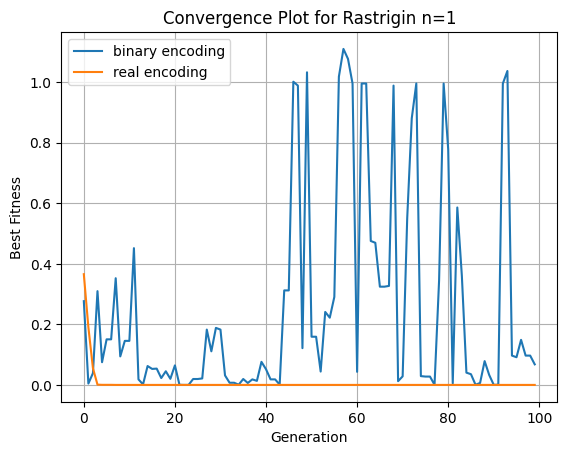

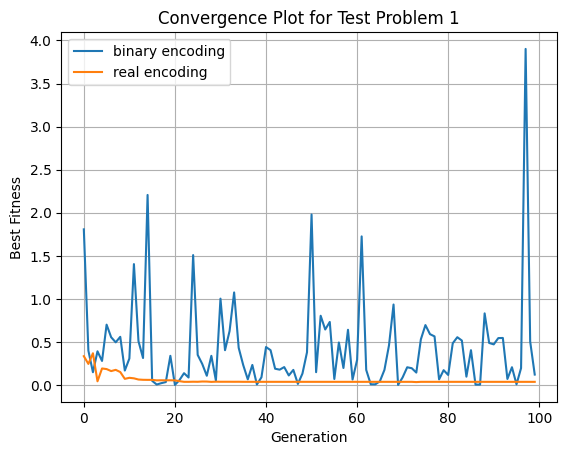

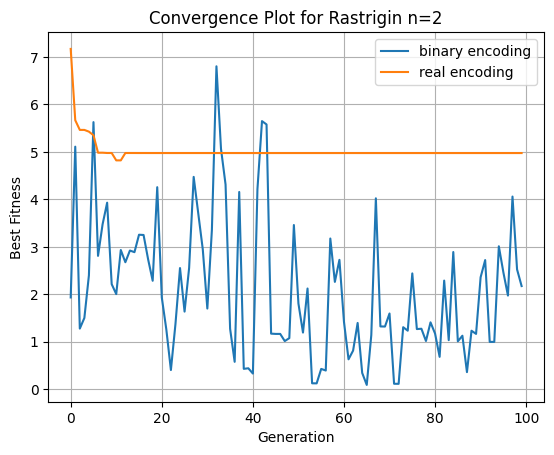

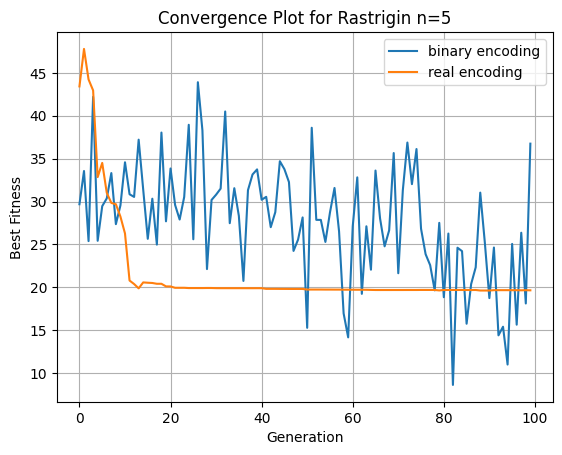

In [18]:
# Generate convergence plots
selected_experiment = np.random.randint(0, n_experiments)  # Randomly select an experiment

print(f"\nGenerating convergence plots for Experiment {selected_experiment + 1}")

for problem_name in problems:
    plt.figure()
    for encoding in encoding_types:
        # Retrieve the convergence data for the selected experiment
        convergence = results[problem_name][encoding]['convergence'][selected_experiment]
        plt.plot(convergence, label=f"{encoding} encoding")
    plt.title(f"Convergence Plot for {problem_name}")
    plt.xlabel("Generation")
    plt.ylabel("Best Fitness")
    plt.legend()
    plt.grid(True)
    plt.show()


We can generate some conclusions from the previous plots, as followings:

- **Test Problem 1 (Rosenbrock Function)**: The real encoding converged faster and to a better solution than binary encoding, which showed more fluctuation in the fitness values over generations.
  
- **Rastrigin Function** (\( n = 2 \) and \( n = 5 \)): Real encoding consistently achieved lower fitness values, indicating better performance, while binary encoding exhibited slower convergence, particularly for larger \( n \).


In [19]:
df_copy = df.drop(['Mean', 'Standard Deviation', 'Min', 'Max'], inplace=False)
df_copy.min()

Rastrigin n=1 (binary encoding)      0.002035
Rastrigin n=1 (real encoding)        0.000000
Test Problem 1 (binary encoding)     0.006079
Test Problem 1 (real encoding)       0.000009
Rastrigin n=2 (binary encoding)      0.105851
Rastrigin n=2 (real encoding)        0.003367
Rastrigin n=5 (binary encoding)     11.397538
Rastrigin n=5 (real encoding)        7.378354
dtype: float64

## 4.3 Comparing with other algorithms

After comparing both encoding types for genetic algorithms, we implemented three traditional methods, which are the hill climber method, gradient descent method and Newthon's method for solving this problems.

In [20]:
def hill_climbing(f, bounds, n_iterations, step_size, dim):
  # Random initialization
  solution = np.random.uniform(bounds[0], bounds[1], dim)
  solution_eval = f(solution)
  
  for i in range(n_iterations):
    # Test in the neighborhood
    candidate = solution + np.random.uniform(-step_size, step_size, len(solution))
    candidate_eval = f(candidate)
    
    # If better then accept
    if candidate_eval < solution_eval:
      solution, solution_eval = candidate, candidate_eval
  
  return solution, solution_eval


In [21]:
from scipy.optimize import minimize

def gradient_descent(f, x0):
  result = minimize(f, x0, method='CG')
  return result.x, result.fun

In [22]:
def newtons_method(f, x0, jac, hess):
    result = minimize(f, x0, method='Newton-CG', jac=jac, hess=hess)
    return result.x, result.fun

In [23]:
# Results for Rastrigin n=1
_, rastrigin_1_hill_climber_result = hill_climbing(rastrigin, RASTRIGIN_BOUNDS, 100, 1e-4, 1)
_, rastrigin_1_gradient_descent_result = gradient_descent(rastrigin, np.random.uniform(RASTRIGIN_BOUNDS[0], RASTRIGIN_BOUNDS[1], 1))
_, rastrigin_1_newton_method_result = newtons_method(rastrigin, np.random.uniform(RASTRIGIN_BOUNDS[0], RASTRIGIN_BOUNDS[1], 1), rastrigin_jac, rastrigin_hess)

print("Rastrigin n=1 Results:")
print(rastrigin_1_hill_climber_result, rastrigin_1_gradient_descent_result, rastrigin_1_newton_method_result)

# Rosenbrock problem
x0_rosenbrock = np.random.uniform(ROSENBROCK_BOUNDS[0], ROSENBROCK_BOUNDS[1], 2)

# Results for Rosenbrock
_, rosenbrock_hill_climber_result = hill_climbing(rosenbrock, ROSENBROCK_BOUNDS, 100, 1e-4, 2)
_, rosenbrock_gradient_descent_result = gradient_descent(rosenbrock, x0_rosenbrock)
_, rosenbrock_newton_method_result = newtons_method(rosenbrock, x0_rosenbrock, rosenbrock_jac, rosenbrock_hess)

print("\nRosenbrock Results:")
print(rosenbrock_hill_climber_result, rosenbrock_gradient_descent_result, rosenbrock_newton_method_result)

# Rastrigin n=2
x0_rastrigin_2 = np.random.uniform(RASTRIGIN_BOUNDS[0], RASTRIGIN_BOUNDS[1], 2)

# Results for Rastrigin n=2
_, rastrigin_2_hill_climber_result = hill_climbing(rastrigin, RASTRIGIN_BOUNDS, 100, 1e-4, 2)
_, rastrigin_2_gradient_descent_result = gradient_descent(rastrigin, x0_rastrigin_2)
_, rastrigin_2_newton_method_result = newtons_method(rastrigin, x0_rastrigin_2, rastrigin_jac, rastrigin_hess)

print("\nRastrigin n=2 Results:")
print(rastrigin_2_hill_climber_result, rastrigin_2_gradient_descent_result, rastrigin_2_newton_method_result)

# Rastrigin n=5
x0_rastrigin_5 = np.random.uniform(RASTRIGIN_BOUNDS[0], RASTRIGIN_BOUNDS[1], 5)

# Results for Rastrigin n=5
_, rastrigin_5_hill_climber_result = hill_climbing(rastrigin, RASTRIGIN_BOUNDS, 100, 1e-4, 5)
_, rastrigin_5_gradient_descent_result = gradient_descent(rastrigin, x0_rastrigin_5)
_, rastrigin_5_newton_method_result = newtons_method(rastrigin, x0_rastrigin_5, rastrigin_jac, rastrigin_hess)

print("\nRastrigin n=5 Results:")
print(rastrigin_5_hill_climber_result, rastrigin_5_gradient_descent_result, rastrigin_5_newton_method_result)

Rastrigin n=1 Results:
16.688615529491713 0.9949590570933022 15.919243792461534

Rosenbrock Results:
83.410997841865 1.2647394507516365e-10 1.9994001924774324e-11

Rastrigin n=2 Results:
20.35338301001046 24.873722934542336 25.86868199163552

Rastrigin n=5 Results:
50.38186808191307 42.78300694059671 64.67187290057348


In [24]:
genetic_algo_min = {
  'rosenbrock_bin': df_copy['Test Problem 1 (binary encoding)'].min(),
  'rosenbrock_real': df_copy['Test Problem 1 (real encoding)'].min(),
  'rastrigin_n1_bin': df_copy['Rastrigin n=1 (binary encoding)'].min(),
  'rastrigin_n1_real': df_copy['Rastrigin n=1 (real encoding)'].min(),
  'rastrigin_n2_bin': df_copy['Rastrigin n=2 (binary encoding)'].min(),
  'rastrigin_n2_real': df_copy['Rastrigin n=2 (real encoding)'].min(),
  'rastrigin_n5_bin': df_copy['Rastrigin n=5 (binary encoding)'].min(),
  'rastrigin_n5_real': df_copy['Rastrigin n=5 (real encoding)'].min()
}

# Create a DataFrame to store the comparison results
data = {
  'Rosenbrock': [rosenbrock_hill_climber_result, rosenbrock_gradient_descent_result, rosenbrock_newton_method_result, genetic_algo_min['rosenbrock_real'], genetic_algo_min['rosenbrock_bin']],
  'Rastrigin n=1': [rastrigin_1_hill_climber_result, rastrigin_1_gradient_descent_result, rastrigin_1_newton_method_result, genetic_algo_min['rastrigin_n1_real'], genetic_algo_min['rastrigin_n1_bin']],
  'Rastrigin n=2': [rastrigin_2_hill_climber_result, rastrigin_2_gradient_descent_result, rastrigin_2_newton_method_result, genetic_algo_min['rastrigin_n2_real'], genetic_algo_min['rastrigin_n2_bin']],
  'Rastrigin n=5': [rastrigin_5_hill_climber_result, rastrigin_5_gradient_descent_result, rastrigin_5_newton_method_result, genetic_algo_min['rastrigin_n5_real'], genetic_algo_min['rastrigin_n5_bin']]
}

comparison_df = pd.DataFrame(data, index=['Hill Climber', 'Gradient Descent', 'Newton Method', 'Genetic Algorithm Real Encoding', 'Genetic Algorithm Binary Encoding'])

The results are summarized below, showing the best fitness achieved by each method:

In [25]:
comparison_df

,Rosenbrock,Rastrigin n=1,Rastrigin n=2,Rastrigin n=5
Hill Climber,8.341100e+01,16.688616,20.353383,50.381868
Gradient Descent,1.264739e-10,0.994959,24.873723,42.783007
Newton Method,1.999400e-11,15.919244,25.868682,64.671873
Genetic Algorithm Real Encoding,8.970065e-06,0.000000,0.003367,7.378354
Genetic Algorithm Binary Encoding,6.078647e-03,0.002035,0.105851,11.397538


From the above table, we can conclude the following: 

- **Test Problem 1 (Rosenbrock Function)**: Newton's method provided the best result due to its use of second-order information (Hessian), while the genetic algorithm using real encoding provided competitive results.
- **Rastrigin Function \( n=2 \)**: The genetic algorithm with real encoding performed comparably to gradient descent, while Newton's method produced the best results.
- **Rastrigin Function \( n=5 \)**: The genetic algorithm with real encoding was highly competitive with the gradient descent method, while Newton's method achieved the best results overall.

Additionally, **as the number of decision variables increases**, genetic algorithms tend to **outperform traditional optimization methods**

## 4.4. Benefits of the Genetic Algorithm

For problems like the Rastrigin function, which has many local minima, the genetic algorithm's stochastic nature allows it to explore the search space more thoroughly than deterministic methods like gradient descent or Newton's method. This can prevent the algorithm from getting trapped in local minima. The real encoding approach was generally more effective, achieving lower fitness values in fewer generations than the binary encoding.

**Combining Derivative-Based Methods with Genetic Algorithm**

One potential improvement is to combine the global exploration capabilities of the genetic algorithm with the local exploitation capabilities of gradient-based methods. After the genetic algorithm has converged, a local optimization method such as gradient descent or Newton’s method could be applied to refine the solution. This hybrid approach could lead to faster convergence and more precise results, particularly for highly multimodal functions like Rastrigin.

# 5. Conclusion

The genetic algorithm was successfully implemented and tested on two challenging optimization problems using both binary and real encoding. Real encoding generally outperformed binary encoding in terms of convergence speed and the quality of the solutions found. When compared to traditional optimization methods, the genetic algorithm showed its strength in solving non-convex problems, especially in cases where local methods struggled with local minima. The combination of genetic algorithms with local optimization methods presents a promising avenue for further exploration.